[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



SVM CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1202
           1       0.99      0.84      0.91       191

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



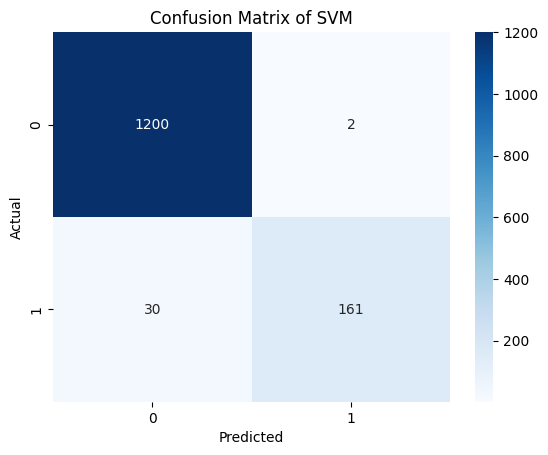


Naive Bayes CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1202
           1       1.00      0.72      0.84       191

    accuracy                           0.96      1393
   macro avg       0.98      0.86      0.91      1393
weighted avg       0.96      0.96      0.96      1393



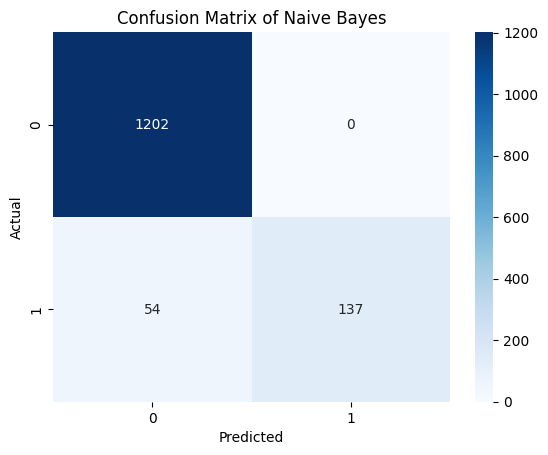

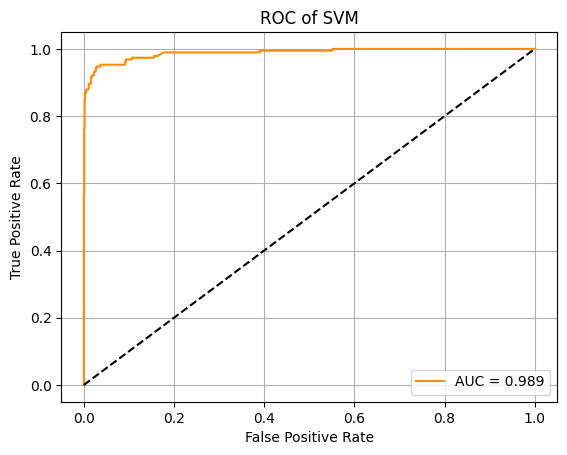

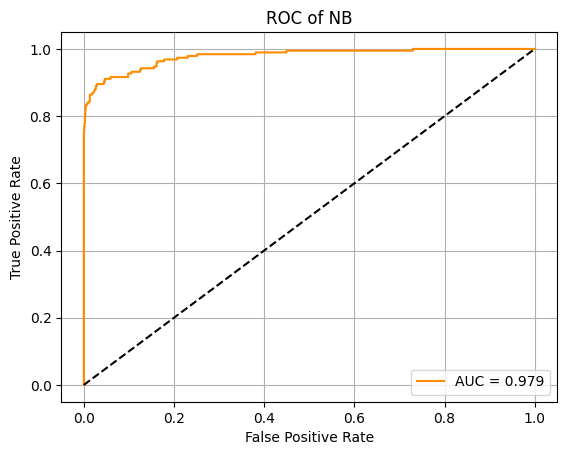

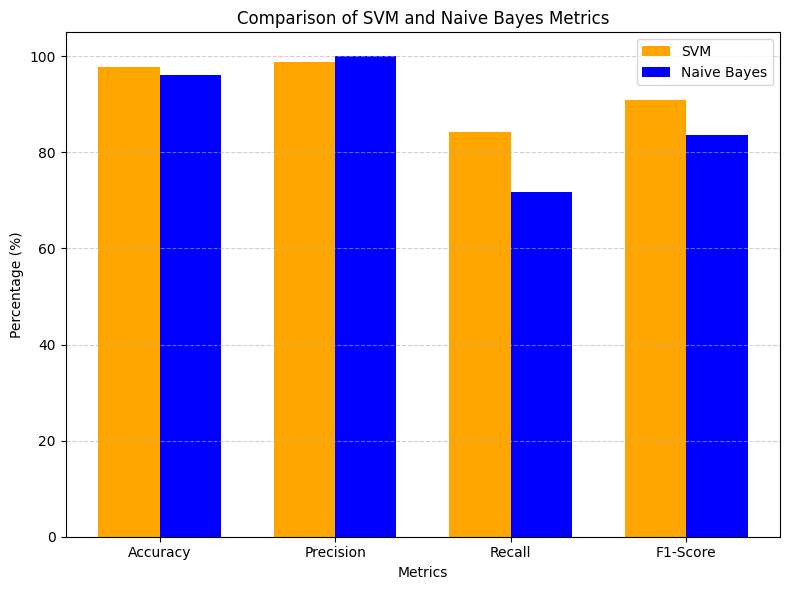

SVM Metrics: {'Accuracy': 97.7, 'Precision': 98.77, 'Recall': 84.29, 'F1-Score': 90.96}
Naive Bayes Metrics: {'Accuracy': 96.12, 'Precision': 100.0, 'Recall': 71.73, 'F1-Score': 83.54}

Enter an SMS message to classify (e.g., 'You won $1000, click here!'):
> Hii!! Good morning, How are you?

🔍 SVM Prediction: HAM (Confidence: 0.22%)
🔍 Naive Bayes Prediction: HAM (Confidence: 2.19%)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)

# 📥 Download NLTK resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# 📂 Load dataset
df = pd.read_csv("/content/sms_spam_dataset.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']

# 🔧 Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned'] = df['message'].apply(clean_text)
le = LabelEncoder()
df['label_num'] = le.fit_transform(df['label'])  # spam=1, ham=0

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned'])
y = df['label_num']

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 🧠 Naive Bayes Model
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
probs_nb = nb.predict_proba(X_test)[:, 1]

# 🧠 SVM Model
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
probs_svm = svm.predict_proba(X_test)[:, 1]

# 📈 Compute metrics
def compute_metrics(y_true, y_pred):
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred) * 100, 2),
        'Precision': round(precision_score(y_true, y_pred) * 100, 2),
        'Recall': round(recall_score(y_true, y_pred) * 100, 2),
        'F1-Score': round(f1_score(y_true, y_pred) * 100, 2)
    }

nb_metrics = compute_metrics(y_test, y_pred_nb)
svm_metrics = compute_metrics(y_test, y_pred_svm)

# 📊 Confusion Matrix Function
def print_metrics(y_test, y_pred, name):
    print(f"\n{name} CLASSIFICATION REPORT\n")
    print(classification_report(y_test, y_pred))

def plot_confusion(y_test, y_pred, title, filename):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(filename, dpi=300)
    plt.show()

# ✅ Print and Plot Confusion Matrices
print_metrics(y_test, y_pred_svm, "SVM")
plot_confusion(y_test, y_pred_svm, "Confusion Matrix of SVM", "confusion_matrix_svm.png")

print_metrics(y_test, y_pred_nb, "Naive Bayes")
plot_confusion(y_test, y_pred_nb, "Confusion Matrix of Naive Bayes", "confusion_matrix_nb.png")

# 📈 ROC CURVE Function
def plot_roc(y_test, probs, title, filename):
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig(filename, dpi=300)
    plt.show()

plot_roc(y_test, probs_svm, "ROC of SVM", "roc_svm.png")
plot_roc(y_test, probs_nb, "ROC of NB", "roc_nb.png")

# 📊 Grouped Bar Chart of Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
svm_scores = [svm_metrics[m] for m in metrics]
nb_scores = [nb_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, svm_scores, width, label='SVM', color='orange')
plt.bar(x + width/2, nb_scores, width, label='Naive Bayes', color='blue')

plt.ylabel('Percentage (%)')
plt.xlabel('Metrics')
plt.title('Comparison of SVM and Naive Bayes Metrics')
plt.xticks(x, metrics)
plt.ylim(0, 105)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("comparison_svm_nb_dynamic.png", dpi=300)
plt.show()

# ✅ Print computed metrics
print("SVM Metrics:", svm_metrics)
print("Naive Bayes Metrics:", nb_metrics)

# ✅🔠 USER INPUT PREDICTION SECTION
def preprocess_input(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# 📩 Get user input
user_message = input("\nEnter an SMS message to classify (e.g., 'You won $1000, click here!'):\n> ")
cleaned_input = preprocess_input(user_message)
X_input = vectorizer.transform([cleaned_input])

# 📌 Predict with SVM
svm_prediction = svm.predict(X_input)[0]
svm_prob = svm.predict_proba(X_input)[0][1]

# 📌 Predict with Naive Bayes
nb_prediction = nb.predict(X_input)[0]
nb_prob = nb.predict_proba(X_input)[0][1]

# 🧾 Decode label
decoded_svm = le.inverse_transform([svm_prediction])[0]
decoded_nb = le.inverse_transform([nb_prediction])[0]

# 🖨️ Show results
print(f"\n🔍 SVM Prediction: {decoded_svm.upper()} (Confidence: {svm_prob*100:.2f}%)")
print(f"🔍 Naive Bayes Prediction: {decoded_nb.upper()} (Confidence: {nb_prob*100:.2f}%)")
